In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


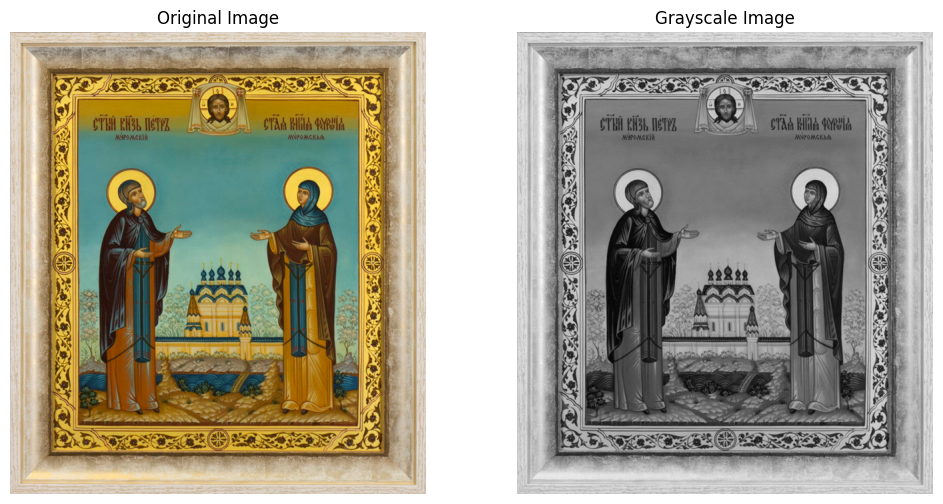

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'/content/drive/MyDrive/dataset/training_set'  # Update this path
output_directory_base = r'/content/drive/MyDrive/dataset/gray_training_set'  # Update this path

# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [ ]:
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'/content/drive/MyDrive/dataset/gray_training_set',
    color_dir=r'/content/drive/MyDrive/dataset/training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'/content/drive/MyDrive/dataset/gray_validation_set',
    color_dir=r'/content/drive/MyDrive/dataset/validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform: PyTorch transforms for transforms and tensor conversion.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform)
        self.color_dataset = ImageFolder(color_dir, transform=transform)
        self.transform = transform

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [ ]:
for inputs, _ in DataLoader(training_data, batch_size=1, shuffle=True):
    print(f"Grayscale image size: {inputs.size()}")
    break  # Print the size of the first batch only to check the dimensions.

Grayscale image size: torch.Size([1, 1, 256, 256])


In [ ]:
import torch
import torch.nn as nn

class ModifiedBottleneck(nn.Module):
    expansion = 2  # Lowered from the original 4 to reduce complexity

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ModifiedBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ColorizationResNet(nn.Module):
    def __init__(self):
        super(ColorizationResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet layers with modified bottleneck
        self.layer1 = self._make_layer(ModifiedBottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(ModifiedBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(ModifiedBottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(ModifiedBottleneck, 512, 3, stride=2)

        # Upsampling layers
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.final_activation = nn.Tanh()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.upsample_layers(x)
        x = self.final_conv(x)
        x = self.final_activation(x)
        x = (x + 1) / 2  # Normalize output to [0, 1]
        return x


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

RESNET_model = ColorizationResNet().cuda()  # Initialize the ResNet model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(RESNET_model.parameters(), lr=0.00005)  # Initial lr=0.00005

num_epochs = 80

scheduler = OneCycleLR(optimizer, max_lr = 0.0001, epochs=num_epochs, steps_per_epoch=len(training_loader))

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    RESNET_model.train()  # Set the ResNet model to training mode
    train_loss = 0.0
    train_loader = tqdm(training_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = RESNET_model(inputs)  # Use the ResNet model for prediction
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        train_loader.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(training_loader)
    training_losses.append(avg_train_loss)
    print(f'\nEpoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    RESNET_model.eval()  # Set the ResNet model to evaluation mode
    validation_loss = 0.0
    validation_loader_tqdm = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for inputs, targets in validation_loader_tqdm:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = RESNET_model(inputs)  # Use the ResNet model for prediction
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
            validation_loader_tqdm.set_postfix(loss=loss.item())

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)
    print(f'\nEpoch {epoch+1}, Validation Loss: {avg_validation_loss:.4f}')

Epoch 1/80 [Training]:  28%|██▊       | 136/483 [56:09<2:20:21, 24.27s/it, loss=0.0867]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/80 [Training]: 100%|██████████| 483/483 [3:11:05<00:00, 23.74s/it, loss=0.0246]



Epoch 1, Training Loss: 0.0612


Epoch 1/80 [Validation]: 100%|██████████| 54/54 [19:56<00:00, 22.15s/it, loss=0.0521]



Epoch 1, Validation Loss: 0.0407


Epoch 2/80 [Training]: 100%|██████████| 483/483 [02:07<00:00,  3.80it/s, loss=0.0139]



Epoch 2, Training Loss: 0.0321


Epoch 2/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.00it/s, loss=0.0153]



Epoch 2, Validation Loss: 0.0152


Epoch 3/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.81it/s, loss=0.0143]



Epoch 3, Training Loss: 0.0154


Epoch 3/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.09it/s, loss=0.0144]



Epoch 3, Validation Loss: 0.0129


Epoch 4/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00924]



Epoch 4, Training Loss: 0.0134


Epoch 4/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.25it/s, loss=0.0174]



Epoch 4, Validation Loss: 0.0116


Epoch 5/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.0112]



Epoch 5, Training Loss: 0.0125


Epoch 5/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.28it/s, loss=0.00581]



Epoch 5, Validation Loss: 0.0107


Epoch 6/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.96it/s, loss=0.0129]



Epoch 6, Training Loss: 0.0115


Epoch 6/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.01]



Epoch 6, Validation Loss: 0.0101


Epoch 7/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.0106]



Epoch 7, Training Loss: 0.0107


Epoch 7/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.33it/s, loss=0.0114]



Epoch 7, Validation Loss: 0.0094


Epoch 8/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00917]



Epoch 8, Training Loss: 0.0100


Epoch 8/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.00988]



Epoch 8, Validation Loss: 0.0088


Epoch 9/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.95it/s, loss=0.00414]



Epoch 9, Training Loss: 0.0096


Epoch 9/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00638]



Epoch 9, Validation Loss: 0.0086


Epoch 10/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.95it/s, loss=0.00744]



Epoch 10, Training Loss: 0.0092


Epoch 10/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.22it/s, loss=0.00541]



Epoch 10, Validation Loss: 0.0083


Epoch 11/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00848]



Epoch 11, Training Loss: 0.0091


Epoch 11/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.0116]



Epoch 11, Validation Loss: 0.0081


Epoch 12/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.0132]



Epoch 12, Training Loss: 0.0087


Epoch 12/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.19it/s, loss=0.00948]



Epoch 12, Validation Loss: 0.0080


Epoch 13/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.0127]



Epoch 13, Training Loss: 0.0084


Epoch 13/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.18it/s, loss=0.00871]



Epoch 13, Validation Loss: 0.0076


Epoch 14/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.91it/s, loss=0.0152]



Epoch 14, Training Loss: 0.0083


Epoch 14/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.19it/s, loss=0.0049]



Epoch 14, Validation Loss: 0.0074


Epoch 15/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00689]



Epoch 15, Training Loss: 0.0082


Epoch 15/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.00724]



Epoch 15, Validation Loss: 0.0077


Epoch 16/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00861]



Epoch 16, Training Loss: 0.0077


Epoch 16/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.25it/s, loss=0.00447]



Epoch 16, Validation Loss: 0.0074


Epoch 17/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.91it/s, loss=0.00898]



Epoch 17, Training Loss: 0.0076


Epoch 17/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.22it/s, loss=0.00606]



Epoch 17, Validation Loss: 0.0075


Epoch 18/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.0108]



Epoch 18, Training Loss: 0.0071


Epoch 18/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.00721]



Epoch 18, Validation Loss: 0.0071


Epoch 19/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.93it/s, loss=0.0112]



Epoch 19, Training Loss: 0.0066


Epoch 19/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.11it/s, loss=0.00816]



Epoch 19, Validation Loss: 0.0073


Epoch 20/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00727]



Epoch 20, Training Loss: 0.0063


Epoch 20/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.01]



Epoch 20, Validation Loss: 0.0069


Epoch 21/80 [Training]: 100%|██████████| 483/483 [02:08<00:00,  3.75it/s, loss=0.01]



Epoch 21, Training Loss: 0.0064


Epoch 21/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.55it/s, loss=0.00996]



Epoch 21, Validation Loss: 0.0074


Epoch 22/80 [Training]: 100%|██████████| 483/483 [02:09<00:00,  3.73it/s, loss=0.00454]



Epoch 22, Training Loss: 0.0056


Epoch 22/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00682]



Epoch 22, Validation Loss: 0.0074


Epoch 23/80 [Training]: 100%|██████████| 483/483 [02:11<00:00,  3.67it/s, loss=0.00569]



Epoch 23, Training Loss: 0.0054


Epoch 23/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.16it/s, loss=0.00975]



Epoch 23, Validation Loss: 0.0066


Epoch 24/80 [Training]: 100%|██████████| 483/483 [02:18<00:00,  3.48it/s, loss=0.00445]



Epoch 24, Training Loss: 0.0053


Epoch 24/80 [Validation]: 100%|██████████| 54/54 [00:12<00:00,  4.45it/s, loss=0.00685]



Epoch 24, Validation Loss: 0.0071


Epoch 25/80 [Training]: 100%|██████████| 483/483 [02:15<00:00,  3.57it/s, loss=0.00379]



Epoch 25, Training Loss: 0.0050


Epoch 25/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.84it/s, loss=0.00681]



Epoch 25, Validation Loss: 0.0066


Epoch 26/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00745]



Epoch 26, Training Loss: 0.0049


Epoch 26/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.00735]



Epoch 26, Validation Loss: 0.0069


Epoch 27/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00589]



Epoch 27, Training Loss: 0.0047


Epoch 27/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.28it/s, loss=0.00529]



Epoch 27, Validation Loss: 0.0063


Epoch 28/80 [Training]: 100%|██████████| 483/483 [02:12<00:00,  3.65it/s, loss=0.00307]



Epoch 28, Training Loss: 0.0046


Epoch 28/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=0.00895]



Epoch 28, Validation Loss: 0.0066


Epoch 29/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.83it/s, loss=0.0072]



Epoch 29, Training Loss: 0.0045


Epoch 29/80 [Validation]: 100%|██████████| 54/54 [00:12<00:00,  4.45it/s, loss=0.00752]



Epoch 29, Validation Loss: 0.0072


Epoch 30/80 [Training]: 100%|██████████| 483/483 [02:09<00:00,  3.73it/s, loss=0.00334]



Epoch 30, Training Loss: 0.0042


Epoch 30/80 [Validation]: 100%|██████████| 54/54 [00:12<00:00,  4.47it/s, loss=0.00724]



Epoch 30, Validation Loss: 0.0077


Epoch 31/80 [Training]: 100%|██████████| 483/483 [02:21<00:00,  3.41it/s, loss=0.00319]



Epoch 31, Training Loss: 0.0041


Epoch 31/80 [Validation]: 100%|██████████| 54/54 [00:12<00:00,  4.50it/s, loss=0.0123]



Epoch 31, Validation Loss: 0.0062


Epoch 32/80 [Training]: 100%|██████████| 483/483 [02:13<00:00,  3.63it/s, loss=0.00679]



Epoch 32, Training Loss: 0.0041


Epoch 32/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.10it/s, loss=0.00654]



Epoch 32, Validation Loss: 0.0066


Epoch 33/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.88it/s, loss=0.00343]



Epoch 33, Training Loss: 0.0039


Epoch 33/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.29it/s, loss=0.00467]



Epoch 33, Validation Loss: 0.0060


Epoch 34/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.89it/s, loss=0.00378]



Epoch 34, Training Loss: 0.0037


Epoch 34/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.25it/s, loss=0.00482]



Epoch 34, Validation Loss: 0.0059


Epoch 35/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.85it/s, loss=0.00562]



Epoch 35, Training Loss: 0.0037


Epoch 35/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.88it/s, loss=0.00937]



Epoch 35, Validation Loss: 0.0064


Epoch 36/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.83it/s, loss=0.00525]



Epoch 36, Training Loss: 0.0037


Epoch 36/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.26it/s, loss=0.00284]



Epoch 36, Validation Loss: 0.0058


Epoch 37/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.91it/s, loss=0.00287]



Epoch 37, Training Loss: 0.0035


Epoch 37/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.21it/s, loss=0.00551]



Epoch 37, Validation Loss: 0.0057


Epoch 38/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00261]



Epoch 38, Training Loss: 0.0034


Epoch 38/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.0039]



Epoch 38, Validation Loss: 0.0057


Epoch 39/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.93it/s, loss=0.00259]



Epoch 39, Training Loss: 0.0033


Epoch 39/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.21it/s, loss=0.00604]



Epoch 39, Validation Loss: 0.0057


Epoch 40/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.0021]



Epoch 40, Training Loss: 0.0032


Epoch 40/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.00363]



Epoch 40, Validation Loss: 0.0057


Epoch 41/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.91it/s, loss=0.00235]



Epoch 41, Training Loss: 0.0031


Epoch 41/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.18it/s, loss=0.00631]



Epoch 41, Validation Loss: 0.0056


Epoch 42/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00382]



Epoch 42, Training Loss: 0.0031


Epoch 42/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.15it/s, loss=0.00224]



Epoch 42, Validation Loss: 0.0058


Epoch 43/80 [Training]: 100%|██████████| 483/483 [02:09<00:00,  3.73it/s, loss=0.00372]



Epoch 43, Training Loss: 0.0030


Epoch 43/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.17it/s, loss=0.00524]



Epoch 43, Validation Loss: 0.0056


Epoch 44/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00206]



Epoch 44, Training Loss: 0.0029


Epoch 44/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.03it/s, loss=0.00728]



Epoch 44, Validation Loss: 0.0057


Epoch 45/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.90it/s, loss=0.00302]



Epoch 45, Training Loss: 0.0028


Epoch 45/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.20it/s, loss=0.00319]



Epoch 45, Validation Loss: 0.0054


Epoch 46/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.93it/s, loss=0.00387]



Epoch 46, Training Loss: 0.0028


Epoch 46/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.16it/s, loss=0.00548]



Epoch 46, Validation Loss: 0.0055


Epoch 47/80 [Training]: 100%|██████████| 483/483 [02:10<00:00,  3.71it/s, loss=0.0072]



Epoch 47, Training Loss: 0.0027


Epoch 47/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.14it/s, loss=0.00652]



Epoch 47, Validation Loss: 0.0056


Epoch 48/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.89it/s, loss=0.00294]



Epoch 48, Training Loss: 0.0027


Epoch 48/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.0076]



Epoch 48, Validation Loss: 0.0055


Epoch 49/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00264]



Epoch 49, Training Loss: 0.0026


Epoch 49/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00402]



Epoch 49, Validation Loss: 0.0054


Epoch 50/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00279]



Epoch 50, Training Loss: 0.0026


Epoch 50/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.26it/s, loss=0.00596]



Epoch 50, Validation Loss: 0.0054


Epoch 51/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00283]



Epoch 51, Training Loss: 0.0025


Epoch 51/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.00394]



Epoch 51, Validation Loss: 0.0055


Epoch 52/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.95it/s, loss=0.00289]



Epoch 52, Training Loss: 0.0024


Epoch 52/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.00427]



Epoch 52, Validation Loss: 0.0054


Epoch 53/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.95it/s, loss=0.00307]



Epoch 53, Training Loss: 0.0024


Epoch 53/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.25it/s, loss=0.00381]



Epoch 53, Validation Loss: 0.0054


Epoch 54/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00267]



Epoch 54, Training Loss: 0.0023


Epoch 54/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.27it/s, loss=0.00424]



Epoch 54, Validation Loss: 0.0055


Epoch 55/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00234]



Epoch 55, Training Loss: 0.0023


Epoch 55/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00759]



Epoch 55, Validation Loss: 0.0054


Epoch 56/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.92it/s, loss=0.00218]



Epoch 56, Training Loss: 0.0023


Epoch 56/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.22it/s, loss=0.00292]



Epoch 56, Validation Loss: 0.0053


Epoch 57/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.90it/s, loss=0.00226]



Epoch 57, Training Loss: 0.0022


Epoch 57/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00665]



Epoch 57, Validation Loss: 0.0053


Epoch 58/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.88it/s, loss=0.00328]



Epoch 58, Training Loss: 0.0022


Epoch 58/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.16it/s, loss=0.006]



Epoch 58, Validation Loss: 0.0053


Epoch 59/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.90it/s, loss=0.00243]



Epoch 59, Training Loss: 0.0021


Epoch 59/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.19it/s, loss=0.00758]



Epoch 59, Validation Loss: 0.0054


Epoch 60/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.87it/s, loss=0.00263]



Epoch 60, Training Loss: 0.0021


Epoch 60/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.17it/s, loss=0.00297]



Epoch 60, Validation Loss: 0.0052


Epoch 61/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.90it/s, loss=0.00252]



Epoch 61, Training Loss: 0.0021


Epoch 61/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.23it/s, loss=0.0069]



Epoch 61, Validation Loss: 0.0053


Epoch 62/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00223]



Epoch 62, Training Loss: 0.0020


Epoch 62/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.22it/s, loss=0.00143]



Epoch 62, Validation Loss: 0.0052


Epoch 63/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00186]



Epoch 63, Training Loss: 0.0020


Epoch 63/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.24it/s, loss=0.00263]



Epoch 63, Validation Loss: 0.0052


Epoch 64/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.93it/s, loss=0.00247]



Epoch 64, Training Loss: 0.0020


Epoch 64/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.27it/s, loss=0.00614]



Epoch 64, Validation Loss: 0.0053


Epoch 65/80 [Training]: 100%|██████████| 483/483 [02:02<00:00,  3.94it/s, loss=0.00181]



Epoch 65, Training Loss: 0.0020


Epoch 65/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.17it/s, loss=0.0069]



Epoch 65, Validation Loss: 0.0053


Epoch 66/80 [Training]: 100%|██████████| 483/483 [02:03<00:00,  3.91it/s, loss=0.00198]



Epoch 66, Training Loss: 0.0020


Epoch 66/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.19it/s, loss=0.00612]



Epoch 66, Validation Loss: 0.0053


Epoch 67/80 [Training]: 100%|██████████| 483/483 [02:04<00:00,  3.87it/s, loss=0.00261]



Epoch 67, Training Loss: 0.0020


Epoch 67/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  4.97it/s, loss=0.00444]



Epoch 67, Validation Loss: 0.0052


Epoch 68/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.83it/s, loss=0.00142]



Epoch 68, Training Loss: 0.0019


Epoch 68/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00357]



Epoch 68, Validation Loss: 0.0052


Epoch 69/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.84it/s, loss=0.00132]



Epoch 69, Training Loss: 0.0019


Epoch 69/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00353]



Epoch 69, Validation Loss: 0.0053


Epoch 70/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.85it/s, loss=0.00162]



Epoch 70, Training Loss: 0.0019


Epoch 70/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.05it/s, loss=0.00286]



Epoch 70, Validation Loss: 0.0052


Epoch 71/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.85it/s, loss=0.000954]



Epoch 71, Training Loss: 0.0019


Epoch 71/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.08it/s, loss=0.00705]



Epoch 71, Validation Loss: 0.0052


Epoch 72/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.84it/s, loss=0.00292]



Epoch 72, Training Loss: 0.0019


Epoch 72/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00432]



Epoch 72, Validation Loss: 0.0053


Epoch 73/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.85it/s, loss=0.00159]



Epoch 73, Training Loss: 0.0019


Epoch 73/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  4.99it/s, loss=0.00446]



Epoch 73, Validation Loss: 0.0052


Epoch 74/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.83it/s, loss=0.00331]



Epoch 74, Training Loss: 0.0019


Epoch 74/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00463]



Epoch 74, Validation Loss: 0.0052


Epoch 75/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.83it/s, loss=0.00114]



Epoch 75, Training Loss: 0.0018


Epoch 75/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00572]



Epoch 75, Validation Loss: 0.0052


Epoch 76/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.84it/s, loss=0.0016]



Epoch 76, Training Loss: 0.0018


Epoch 76/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00449]



Epoch 76, Validation Loss: 0.0052


Epoch 77/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.84it/s, loss=0.0028]



Epoch 77, Training Loss: 0.0018


Epoch 77/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.06it/s, loss=0.00692]



Epoch 77, Validation Loss: 0.0052


Epoch 78/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.84it/s, loss=0.00234]



Epoch 78, Training Loss: 0.0018


Epoch 78/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.07it/s, loss=0.00585]



Epoch 78, Validation Loss: 0.0052


Epoch 79/80 [Training]: 100%|██████████| 483/483 [02:06<00:00,  3.83it/s, loss=0.00287]



Epoch 79, Training Loss: 0.0018


Epoch 79/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.14it/s, loss=0.00656]



Epoch 79, Validation Loss: 0.0052


Epoch 80/80 [Training]: 100%|██████████| 483/483 [02:05<00:00,  3.83it/s, loss=0.00207]



Epoch 80, Training Loss: 0.0018


Epoch 80/80 [Validation]: 100%|██████████| 54/54 [00:10<00:00,  5.13it/s, loss=0.00328]


Epoch 80, Validation Loss: 0.0052


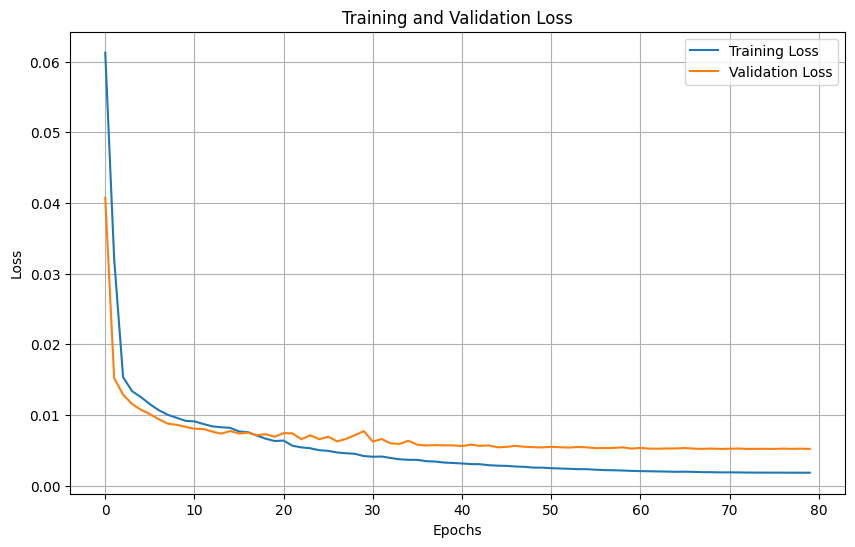

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

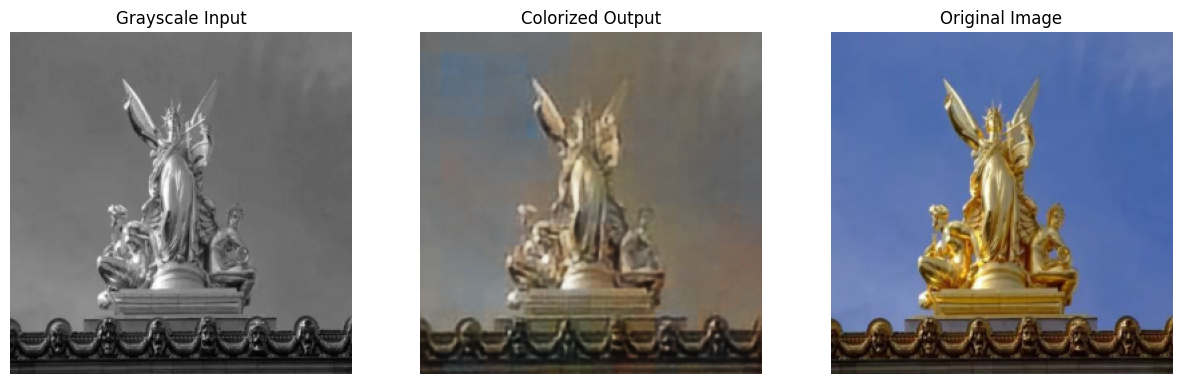

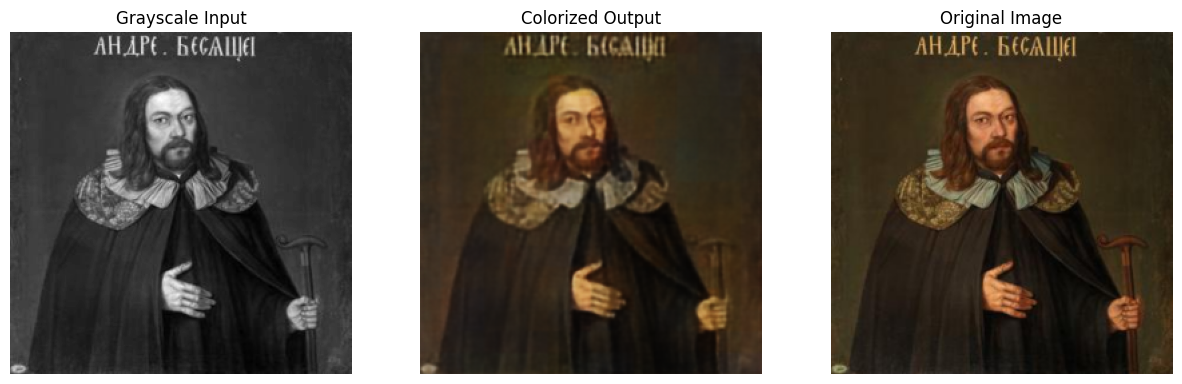

In [ ]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

# Assuming `model`, `validation_loader` are already defined and ready to use
RESNET_model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = RESNET_model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[1], colorized_outputs[1], original_colors[1])
    visualize_results(grayscale_inputs[10], colorized_outputs[10], original_colors[10])

In [ ]:
model_path = r'/content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization/model/artifact/resnet_loss=MSE_batch16_OneCycleLR/model_state_dict.pth'
torch.save(RESNET_model.state_dict(), model_path)

In [ ]:
import csv

# Specify the path to the CSV file where you want to save the losses
csv_file_path = model_path+'losses.csv'

# Open the file in write mode
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

    # Write the losses for each epoch
    for epoch in range(num_epochs):
        writer.writerow([epoch + 1, training_losses[epoch], validation_losses[epoch]])

print(f"Losses saved to {csv_file_path}")

Losses saved to /content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization/model/artifact/resnet_loss=MSE_batch16_OneCycleLR/model_state_dict.pthlosses.csv


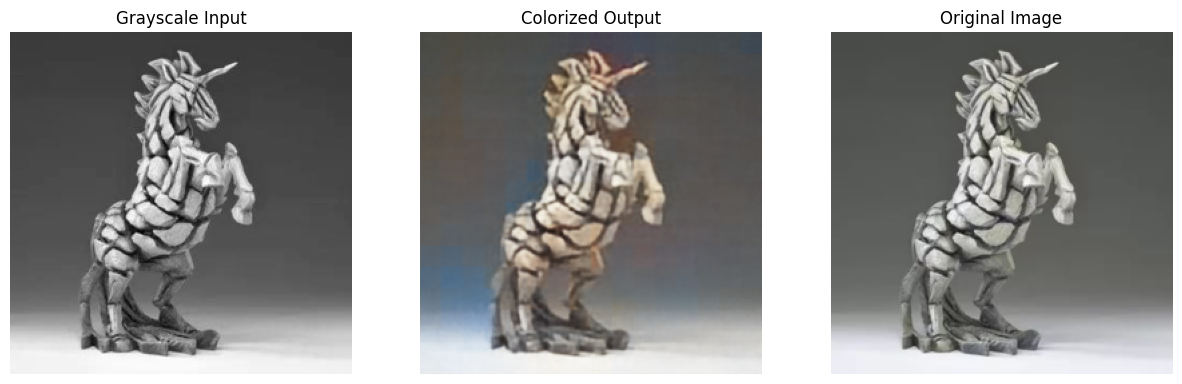

In [ ]:
model = ColorizationResNet().cuda()  # Or just ECCVGenerator() if not using CUDA

# Load the weights back
model.load_state_dict(torch.load(model_path))

# Don't forget to call model.eval() if you're in inference mode
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[5], colorized_outputs[5], original_colors[5])